# Changes in M2, Real Personal Consumption Expenditures (PCE), Wage Inflation, and CPI
Analysis of changes in M2, Real Personal Consumption Expenditures, Average Hourly Earnings of All Employees (aka. Wage Inflation), and CPI at annual rates expressed as percent change from quarter one year ago. I also analyze the composition of M2 and how it has been evolving, as well as look at correlations between changes in M2, PCE, and CPI.

For analyses involving PCE, I make use of data series with quarterly frequencies provided by FRED. In cases where only monthly freqencies are available, I downsample to a quarter start by taking the average over the quarter. I calculate annual percentage changes by comparing values in a given quarter with those 4 quarters prior. Alternatively, [the methodology as used by U.S. Bureau of Economic Analysis](https://www.bea.gov/help/faq/122) can be used to translate changes between two adjacent quarters into annual rates. If you want to use it, uncomment the corresponding line in Cell 3.

For analyses of hourly wages, CPI and M2 I use data series with monthly frequencies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

### Get M2, Real PCE, and CPI data
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `M2SL`&mdash; M2, seasonally adjusted (monthly frequency)
* `PCECC96` &mdash; Real Personal Consumption Expenditures in billions of Chained 2012 Dollars, seasonally adjusted (quarterly frequency)
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, Index 1982-1984=100, seasonally adjusted (monthly frequency)

Ideally I'd have preferred to use the corresponding seasonally unadjusted series, however these are not available for PCE for earlier years than 2002. Therefore for consistency's sake **I use seasonally adjusted series** throughout this notebook. I use plain M2 rather than real M2. This is because otherwise the analysis would show a spurious correlation between declines in M2 and increases in CPI (which is obvious as real M2 for year X is discounted retroactively using the CPI over year X). On the other hand I deliberately use real PCE as otherwise it would show too strong a  positive correlation with CPI (which is again easy to see as plain PCE incorporates CPI, whereas real PCE doesn't).

In [3]:
m2_cpi = web.get_data_fred(['M2SL', 'CPIAUCSL'], start=report_start, end=report_end)

# Downsampling to quarterly frequency to be consistent with PCE frequency
m2_cpi = m2_cpi.resample('QS').mean()

pce = web.get_data_fred('PCECC96', start=report_start, end=report_end)

m2_pce_cpi = pd.concat([m2_cpi, pce], axis=1)

# Converting to annual percentage changes (using U.S. Bureau of Economic Analysis methodology)
# m2_pce_cpi.update(((m2_pce_cpi/m2_pce_cpi.shift(1)).pow(4)-1))

# Converting to annual percentage changes (changes from the corresponding quarter a year ago)
m2_pce_cpi.update(m2_pce_cpi.pct_change(4))

# Drop the first 4 quarters to ensure we don't skew the means
m2_pce_cpi = m2_pce_cpi.loc[m2_pce_cpi.index[4]:]

In [4]:
CPI_COLUMN_NAME = 'Annual CPI'
PCE_COLUMN_NAME = 'Real PCE Annual Percentage Change'
m2_pce_cpi.rename(
    columns={'M2SL': 'M2 Annual Percentage Change', 'CPIAUCSL': CPI_COLUMN_NAME,
             'PCECC96': PCE_COLUMN_NAME},
    inplace=True)
pd.options.display.float_format = '{:.4%}'.format
m2_pce_cpi

,M2 Annual Percentage Change,Annual CPI,Real PCE Annual Percentage Change
DATE,,,
1960-01-01,3.7522%,1.3911%,3.7035%
1960-04-01,3.0694%,1.8249%,3.4145%
1960-07-01,3.5011%,1.3588%,1.9362%
1960-10-01,4.6444%,1.3960%,1.9534%
1961-01-01,5.9158%,1.5081%,0.9498%
...,...,...,...
2023-04-01,-4.0901%,4.0316%,1.8208%
2023-07-01,-3.9066%,3.5618%,2.2078%
2023-10-01,-3.1708%,3.2362%,2.7373%


### Visualizing annual changes in M2, Real PCE, and CPI
There's a very high negative correlation between changes in the real money supply and inflation. This is particularly pronounced during the 1960-1986 period when we saw bouts of high inflation.

In [5]:
GRAPH_TITLE = 'US Annual Percentage Changes in M2, Real PCE, and CPI from %d' % m2_pce_cpi.index[0].year
LABEL_MEAN_M2_PCE_CPI = 'Mean Level of Annual Changes in M2, PCE, and CPI'

In [6]:
# Mean level of M2, PCE, and CPI
mean_level_m2_pce_cpi = m2_pce_cpi.mean().mean()

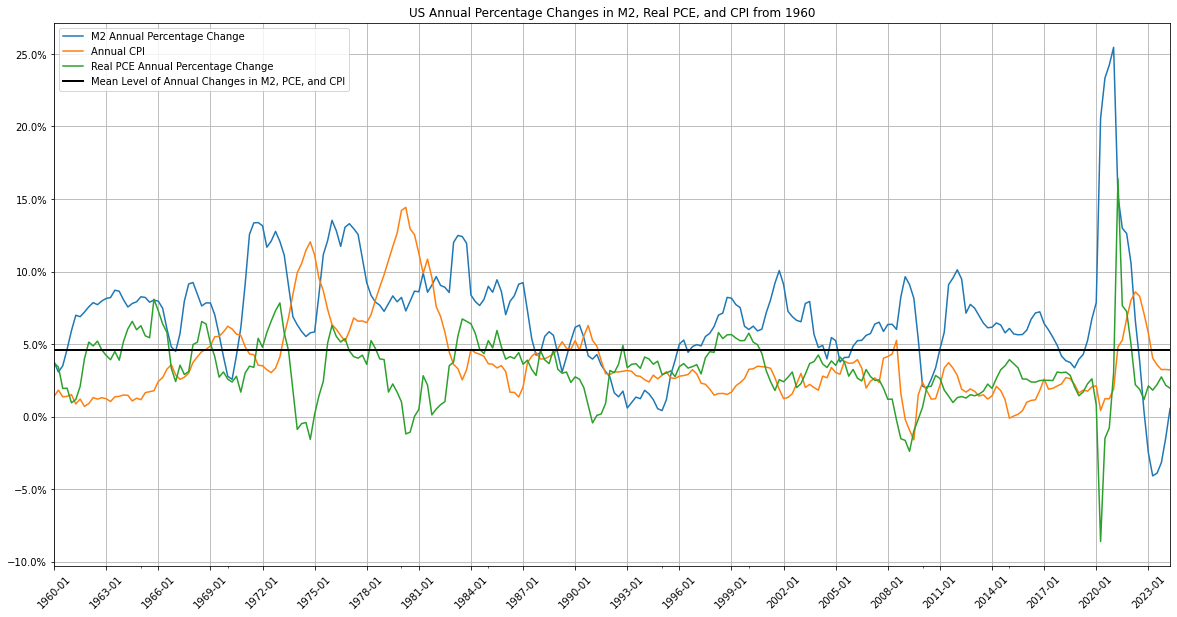

In [7]:
ax = m2_pce_cpi.plot(figsize=(20,10), grid=True, title=GRAPH_TITLE,
                     xticks=m2_pce_cpi.index[::12], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=mean_level_m2_pce_cpi, lw=2, c='k', label=LABEL_MEAN_M2_PCE_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_pce_cpi.index[::12])))

It's interesting to look at the period with high inflation, which took place 1955-1985 separately.

In [8]:
m2_pce_cpi_85 = m2_pce_cpi.loc[:'1986']

### Correlations
* **CPI and PCE**: Increases in inflation correlate strongly with a reduction in personal consumption, the correlation is yet stronger with a PCE lag of a quarter. Inflation leads to a reduction in consumption.
* **M2 and PCE**: Moderate positive correlation, it gets a little stronger with a PCE lag of a quarter. Increaes in the broad money supply lead to increases in personal consumption, albeit not so strongly as the errosion of personal consumption by increases in inflation.
* **M2 and CPI**: No immediate sizable correlation, however it becomes noticable after 2 years &mdash; i.e. M2 changes in a given quarter correlate positively with CPI in about 2 years later. The initiation of a more conservative monetary policy has appreciable effect on reducing inflation over a 2 year horizon.

In [9]:
pd.options.display.float_format = None
m2_pce_cpi.corr()

,M2 Annual Percentage Change,Annual CPI,Real PCE Annual Percentage Change
M2 Annual Percentage Change,1.000000,0.069897,0.121612
Annual CPI,0.069897,1.000000,-0.156056
Real PCE Annual Percentage Change,0.121612,-0.156056,1.000000


Shifting PCE by a quarter ahead shows that its negative correlation with CPI increases further and so does its positive correlation with changes in the broad money supply:

In [10]:
pce = m2_pce_cpi.loc[:, PCE_COLUMN_NAME]
m2_pce_cpi.iloc[:, :2].corrwith(pce.shift(-1))

M2 Annual Percentage Change    0.279874
Annual CPI                    -0.231616
dtype: float64

Shifting CPI changes 2-3 years ahead shows a sizable effect of a stricter monetary policy on reducig inflation in about 2 years' time

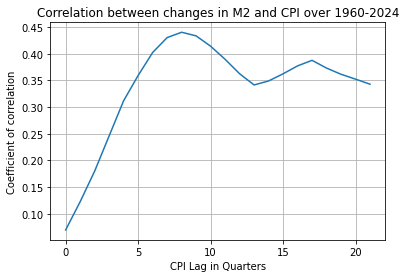

In [11]:
idx = pd.Index(range(22), name='CPI Lag in Quarters')
cpi = m2_pce_cpi.loc[:, CPI_COLUMN_NAME]
m2 = m2_pce_cpi.iloc[:, 0]
effect_of_M2_shrinking = pd.Series(idx.map(lambda lag: m2.corr(cpi.shift(-lag))), index=idx)
_ = effect_of_M2_shrinking.plot(grid=True, title='Correlation between changes in M2 and CPI over %d-%d' % (m2.index[0].year, m2.index[-1].year),
                                ylabel='Coefficient of correlation')

A very high correlation of about 44% between tightening broad money supply (M2) and CPI inflation that manifests itself with a lag of 2-3 years. Let's now repeat the analysis but limit it to the period of consistently high inflation, which took place between 1955 and 1985.

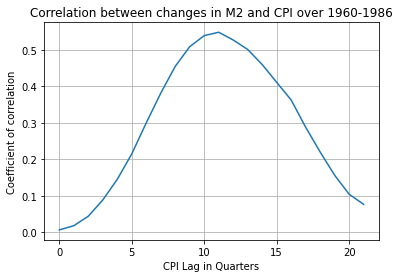

In [12]:
cpi = m2_pce_cpi_85.loc[:, CPI_COLUMN_NAME]
m2 = m2_pce_cpi_85.iloc[:, 0]
effect_of_M2_shrinking = pd.Series(idx.map(lambda lag: m2.corr(cpi.shift(-lag))), index=idx)
_ = effect_of_M2_shrinking.plot(grid=True, title='Correlation between changes in M2 and CPI over %d-%d' % (m2.index[0].year, m2.index[-1].year),
                                ylabel='Coefficient of correlation')

We see an even stronger correlation of 55% with the same lag of about 2-3 years.

Will the history repeat itself &mdash; i.e. the reduction in broad money supply that started in 2022 leading to a reduction in inflation in 2024?

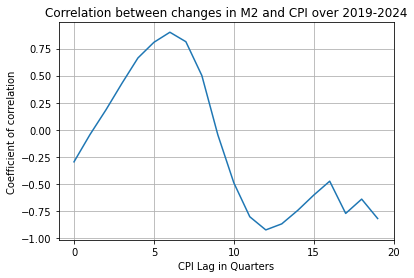

In [13]:
idx = pd.Index(range(20), name='CPI Lag in Quarters')
cpi = m2_pce_cpi.loc['2019':, CPI_COLUMN_NAME]
m2 = m2_pce_cpi.loc['2019':, m2_pce_cpi.columns[0]]
effect_of_M2_shrinking = pd.Series(idx.map(lambda lag: m2.corr(cpi.shift(-lag))), index=idx)
_ = effect_of_M2_shrinking.plot(grid=True, title='Correlation between changes in M2 and CPI over %d-%d' % (m2.index[0].year, m2.index[-1].year),
                                ylabel='Coefficient of correlation', xticks=range(0, 21, 5))

It clearly is pointing in this direction &mdash; we see a correlation of 90% with a lag of about 2 years.

### Consumer Price Index (CPI) vs Personal Consumption Expenditures (PCE) Price Index
Both Consumer Price Index (CPI) for All Urban Consumers as well as Personal Consumption Expenditures Price Price Index are used to guage inflation. They are based on different methodologies: the CPI index is an average based on a Laspeyres formula, whereas the PCE index is based on a Fisher-Ideal formula. A Fisher-Ideal index is considered a “superlative” index in that it reflects consumer substitution. The also have slightly different scopes &mdash; the scope of PCE Price Index is broader and also includes expenditures of nonprofit institutions serving households. For example, medical care services paid for by employers through employer-provided health insurance, as well as medical care services paid for by governments through programs such as Medicare and Medicaid. For more details on the differences please refer to [this article](https://www.bls.gov/opub/btn/archive/differences-between-the-consumer-price-index-and-the-personal-consumption-expenditures-price-index.pdf).

The PCE Price index is the Federal Reserve’s preferred measure of inflation. 

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/) for this analysis:
* `PCEPI` &mdash; Personal Consumption Expenditures: Chain-type Price Index, Index 2012=100, seasonally adjusted (monthly frequency)
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, seasonally adjusted (monthly frequency)

In [14]:
pcepi_cpi = web.get_data_fred(['PCEPI', 'CPIAUCSL'], start=report_start, end=report_end)

# Converting to annual percentage changes (changes from the corresponding month a year ago)
pcepi_cpi.update(pcepi_cpi.pct_change(12))
pcepi_cpi = pcepi_cpi.loc['2003':]

In [15]:
GRAPH_TITLE_PCE_CPI = 'US Annual Percentage Changes in Personal Consumption Expenditures Price Index (PCEPI)'\
                      ' and Consumer Price Index (CPI)'
pcepi_cpi.rename(
    columns={'CPIAUCSL': 'Annual seasonaly adjusted CPI',
             'PCEPI': 'Annual seasonaly adjusted PCEPI'},
    inplace=True)

In [16]:
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
pcepi_cpi.loc['2020-01':]

,Annual seasonaly adjusted PCEPI,Annual seasonaly adjusted CPI
DATE,,
2020-01-01,1.6979%,2.5123%
2020-02-01,1.6420%,2.3397%
2020-03-01,1.1469%,1.5231%
2020-04-01,0.4111%,0.3499%
2020-05-01,0.4486%,0.2162%
...,...,...
2024-01-01,2.4830%,3.1060%
2024-02-01,2.4969%,3.1657%
2024-03-01,2.7207%,3.4751%


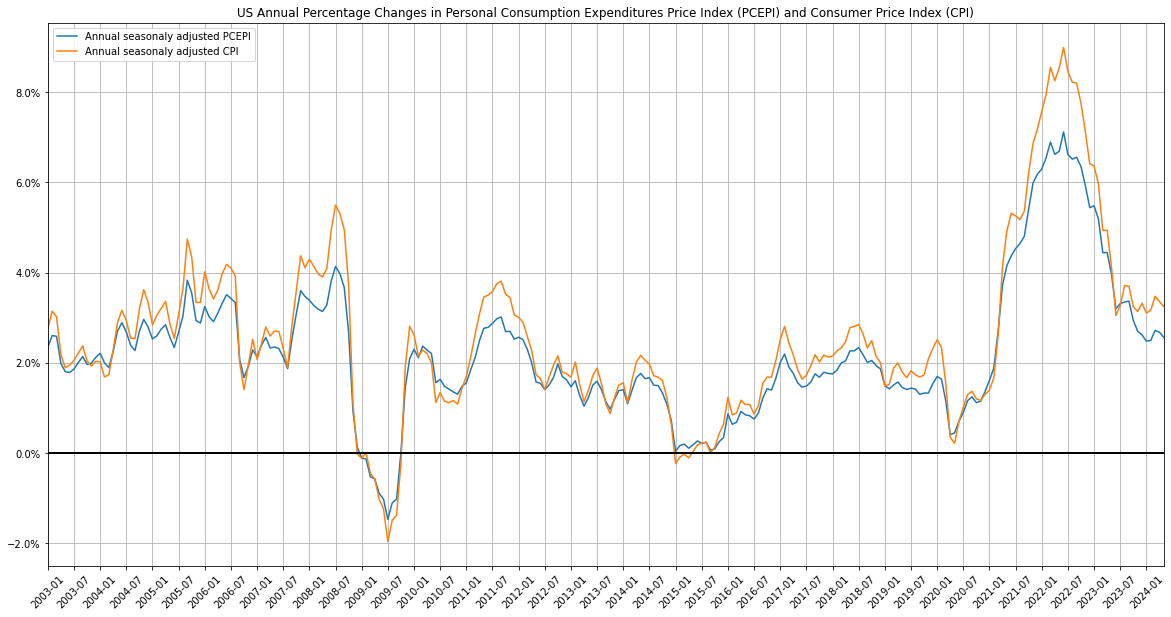

In [17]:
ax = pcepi_cpi.plot(figsize=(20,10), grid=True,
                              title=GRAPH_TITLE_PCE_CPI,
                              xticks=pcepi_cpi.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pcepi_cpi.index[::6])))

#### Personal Consumption Expenditures (PCE) Price Index based on quarterly changes
In the previous part of this notebook I looked at PCEPI based on changes compared to 12 months ago. This is the standard way of determining annual percentage cahnges. Below I look at changes in PCEPI over the previous 3 months and then translate them into annual percentage changes using the following simple formula for translating quarterly PCEPI changes into annual percentage changes:

$$\left(\left({\text{level of month n+1} \over \text{level of month n-2}}\right)^4-1\right)\times 100\% $$

In [18]:
pcepi = web.get_data_fred('PCEPI', start=report_start, end=report_end)
pcepi_monthly = pcepi.pct_change(fill_method='bfill').loc['2017':, 'PCEPI'].rename('PCEPI Percentage Change over Prev Month')
pcepi_annual = ((pcepi/pcepi.shift(1)).pow(12)-1).loc['2017':, 'PCEPI'].rename('PCEPI Change over Prev Month at Annual Rate')
pcepi_quarterly = ((pcepi/pcepi.shift(3)).pow(4)-1).loc['2017':, 'PCEPI'].rename('PCEPI Change over Prev 3 Months at Annual Rate')

In [19]:
pcepi_df = pd.concat([pcepi_cpi.loc['2017':, pcepi_cpi.columns[0]], pcepi_quarterly], axis=1)

In [20]:
pcepi_df.loc['2020':]

,Annual seasonaly adjusted PCEPI,PCEPI Change over Prev 3 Months at Annual Rate
DATE,,
2020-01-01,1.6979%,1.9260%
2020-02-01,1.6420%,2.1479%
2020-03-01,1.1469%,-0.1687%
2020-04-01,0.4111%,-2.5110%
2020-05-01,0.4486%,-2.5050%
...,...,...
2024-01-01,2.4830%,2.1840%
2024-02-01,2.4969%,3.5789%
2024-03-01,2.7207%,4.4666%


In [21]:
import seaborn as sns
cm = sns.color_palette('Blues', as_cmap=True)
IDX_FORMAT = '{:%Y-%m}'
pd.options.display.max_rows = 15

In [22]:
pcepi_df.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=pcepi_df.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Annual seasonaly adjusted PCEPI,PCEPI Change over Prev 3 Months at Annual Rate
DATE,,
2022-12,5.44%,3.57%
2023-01,5.48%,4.03%
2023-02,5.19%,4.41%
2023-03,4.44%,4.06%
2023-04,4.45%,3.00%
2023-05,3.96%,2.14%
2023-06,3.20%,2.33%
2023-07,3.31%,1.61%
2023-08,3.35%,2.64%


### Analysis of annual changes in the main components of Real PCE
Since PCE makes up for about 70% of the GDP, amalysis of changes in the main components of PCE provides insight into what impacts GDP changes the most.

I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/) for this analysis:
* `PCEC96` &mdash; Real Personal Consumption Expenditures in billions of Chained 2012 Dollars, seasonally adjusted (monthly frequency)
* `PCEDGC96` &mdash; Real Personal Consumption Expenditures: Durable Goods in billions of Chained 2012 Dollars, seasonally adjusted (monthly frequency)
* `PCENDC96` &mdash; Real Personal Consumption Expenditures: Nondurable Goods in billions of Chained 2012 Dollars, seasonally adjusted (monthly frequency)
* `PCESC96` &mdash; Real Personal Consumption Expenditures: Services in billions of Chained 2012 Dollars, seasonally adjusted (monthly frequency)

In [23]:
pce_components = web.get_data_fred(['PCEC96', 'PCEDGC96', 'PCENDC96', 'PCESC96'], start=report_start, end=report_end)

# Converting to annual percentage changes (changes from the corresponding month a year ago)
pce_components.update(pce_components.pct_change(12))
pce_components = pce_components.loc['2008':]

In [24]:
PCE_COLUMN_NAME = 'Real PCE Annual Percentage Change'
PCE_DG_COLUMN_NAME = 'Real PCE Durable Goods Annual Percentage Change'
PCE_NDG_COLUMN_NAME = 'Real PCE Nondurable Goods Annual Percentage Change'
PCE_SV_COLUMN_NAME = 'Real PCE Services Annual Percentage Change'
GRAPH_TITLE_PCE = 'US Annual Percentage Changes in Real PCE'
GRAPH_TITLE_PCE_COMPONENTS = 'US Annual Percentage Changes in Main Components of Real PCE'
pce_components.rename(
    columns={'PCEC96': PCE_COLUMN_NAME, 'PCEDGC96': PCE_DG_COLUMN_NAME,
             'PCENDC96': PCE_NDG_COLUMN_NAME, 'PCESC96': PCE_SV_COLUMN_NAME},
    inplace=True)

In [25]:
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
pce_components.loc['2020-01':]

,Real PCE Annual Percentage Change,Real PCE Durable Goods Annual Percentage Change,Real PCE Nondurable Goods Annual Percentage Change,Real PCE Services Annual Percentage Change
DATE,,,,
2020-01-01,3.4141%,7.3100%,2.2699%,3.1476%
2020-02-01,3.2405%,6.9707%,2.8029%,2.7785%
2020-03-01,-4.2256%,-9.0921%,6.0523%,-6.6023%
2020-04-01,-14.6947%,-19.3914%,-6.9545%,-16.3455%
2020-05-01,-7.9914%,3.0459%,0.4998%,-12.2067%
...,...,...,...,...
2024-01-01,1.8515%,-0.0295%,1.6372%,2.2473%
2024-02-01,2.0410%,1.0192%,0.7668%,2.6228%
2024-03-01,2.5772%,2.6207%,2.4970%,2.5814%


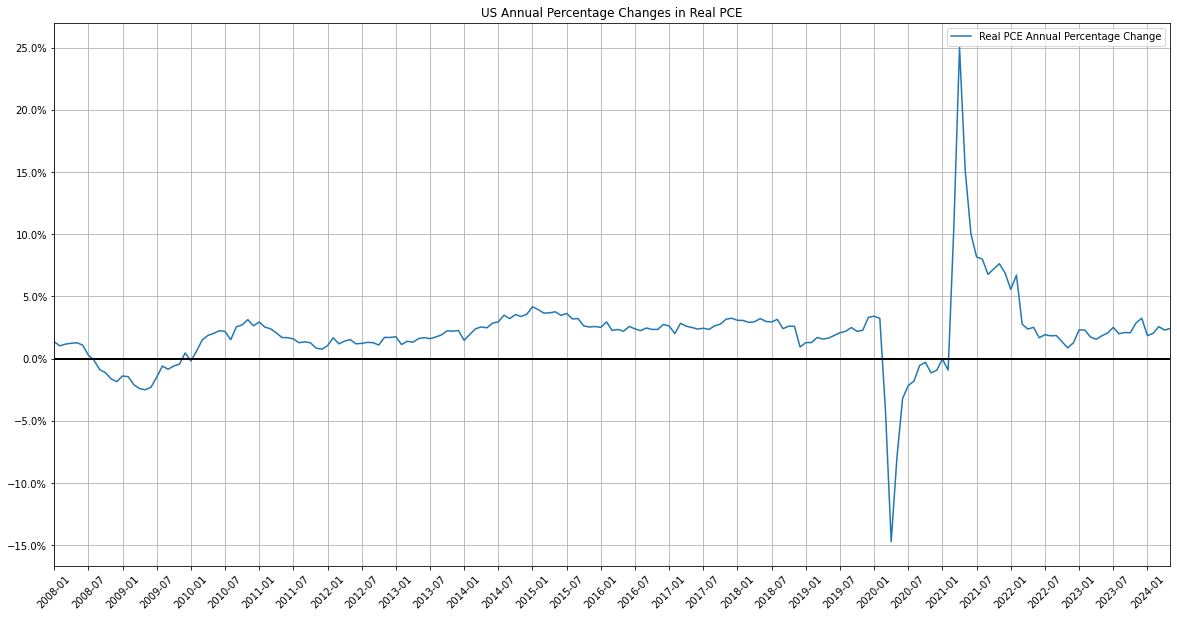

In [26]:
pce_only_components = pce_components.iloc[:, :1]
ax = pce_only_components.plot(figsize=(20,10), grid=True,
                              title=GRAPH_TITLE_PCE,
                              xticks=pce_components.index[::6], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pce_components.index[::6])))

#### Zooming in on the last two years for better visualization

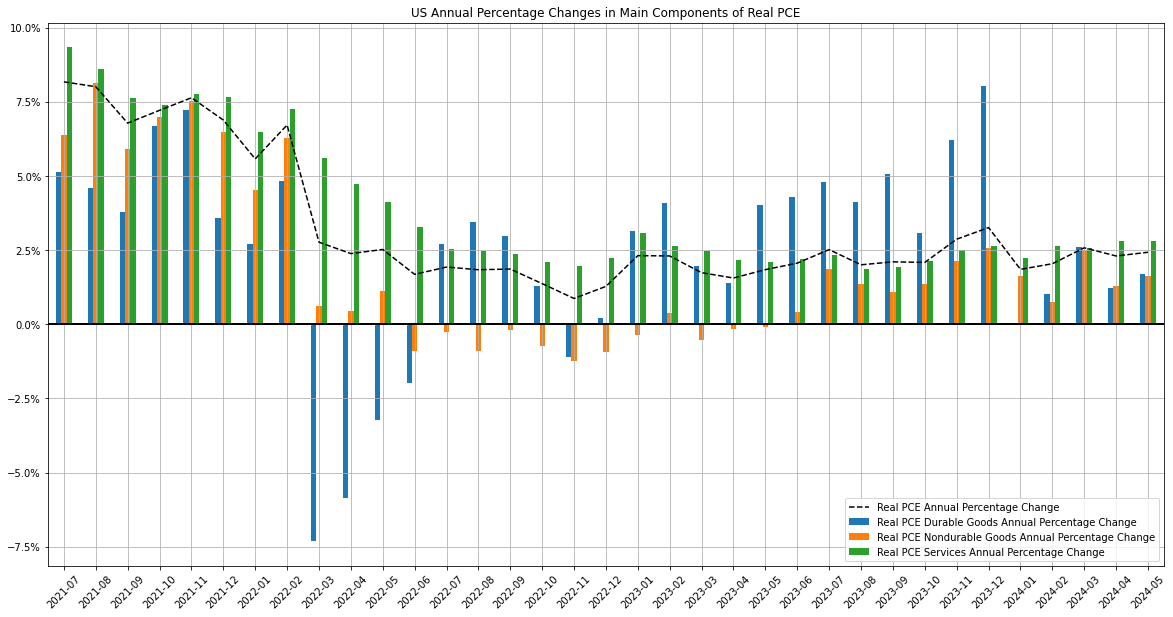

In [27]:
dt_from = date(2021, 7, 1)
pce_components_recent = pce_components.loc[dt_from:]
ax = pce_components_recent.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_PCE_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
pce_components_recent.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, pce_components_recent.index)))

### Get M2, Hourly Wages, and CPI data
Since the series for Hourly Wages are maintained since 2006, let's carry out additional analysis and visualization using dataseries with monthly frequencies
I use the following dataseries provided by [FRED](https://fred.stlouisfed.org/):
* `M2SL`&mdash; M2, seasonally adjusted (monthly frequency)
* `CES0500000003` &mdash; Average Hourly Earnings of All Employees, dollars per hour, seasonally adjusted (monthly frequency)
* `CPIAUCSL` &mdash; Consumer Price Index for All Urban Consumers, Index 1982-1984=100, seasonally adjusted (monthly frequency)

I use plain M2 rather than real M2. This is because otherwise the analysis would show a spurious correlation between declines in M2 and increases in CPI (which is obvious as real M2 for year X is discounted retroactively using the CPI over year X). On the other hand I deliberately use real PCE as otherwise it would show too strong a  positive correlation with CPI (which is again easy to see as plain PCE incorporates CPI, whereas real PCE doesn't).

In [28]:
m2_wagei_cpi = web.get_data_fred(['M2SL', 'CES0500000003', 'CPIAUCSL'], start=date(2006, 3, 1), end=report_end)

# Converting to annual percentage changes (using U.S. Bureau of Economic Analysis methodology)
# m2_pce_cpi.update(((m2_pce_cpi/m2_pce_cpi.shift(1)).pow(4)-1)*100)

# Converting to annual percentage changes (changes from the corresponding month a year ago)
m2_wagei_cpi.update(m2_wagei_cpi.pct_change(12, fill_method='bfill'))

m2_wagei_cpi = m2_wagei_cpi.loc['2007-03':]

In [29]:
CPI_COLUMN_NAME = 'Annual CPI'
WGI_COLUMN_NAME = 'Hourly Earnings Annual Percentage Change'
m2_wagei_cpi.rename(
    columns={'M2SL': 'M2 Annual Percentage Change', 'CPIAUCSL': CPI_COLUMN_NAME,
             'CES0500000003': WGI_COLUMN_NAME},
    inplace=True)
pd.options.display.float_format = '{:.4%}'.format
m2_wagei_cpi

,M2 Annual Percentage Change,Hourly Earnings Annual Percentage Change,Annual CPI
DATE,,,
2007-03-01,5.8584%,3.3915%,2.7982%
2007-04-01,6.3411%,3.1266%,2.5929%
2007-05-01,6.4420%,3.5271%,2.7099%
2007-06-01,6.3361%,3.5591%,2.6928%
2007-07-01,6.1383%,3.2528%,2.3179%
...,...,...,...
2024-01-01,-2.2075%,4.3544%,3.1060%
2024-02-01,-1.9007%,4.2534%,3.1657%
2024-03-01,-0.2904%,4.1429%,3.4751%


In [30]:
# Mean level of M2, Wage Inflation, and CPI
mean_level_wagei = m2_wagei_cpi.iloc[:,1].mean()
mean_level_cpi = m2_wagei_cpi.iloc[:,2].mean()

In [31]:
GRAPH_TITLE = 'US Annual Percentage Changes in M2, Hourly Wages, and CPI from %d'
LABEL_MEAN_WAGEI = 'Mean Level of Annual Changes in Hourly Wages'
LABEL_MEAN_CPI = 'Mean Level of Annual Changes in CPI'

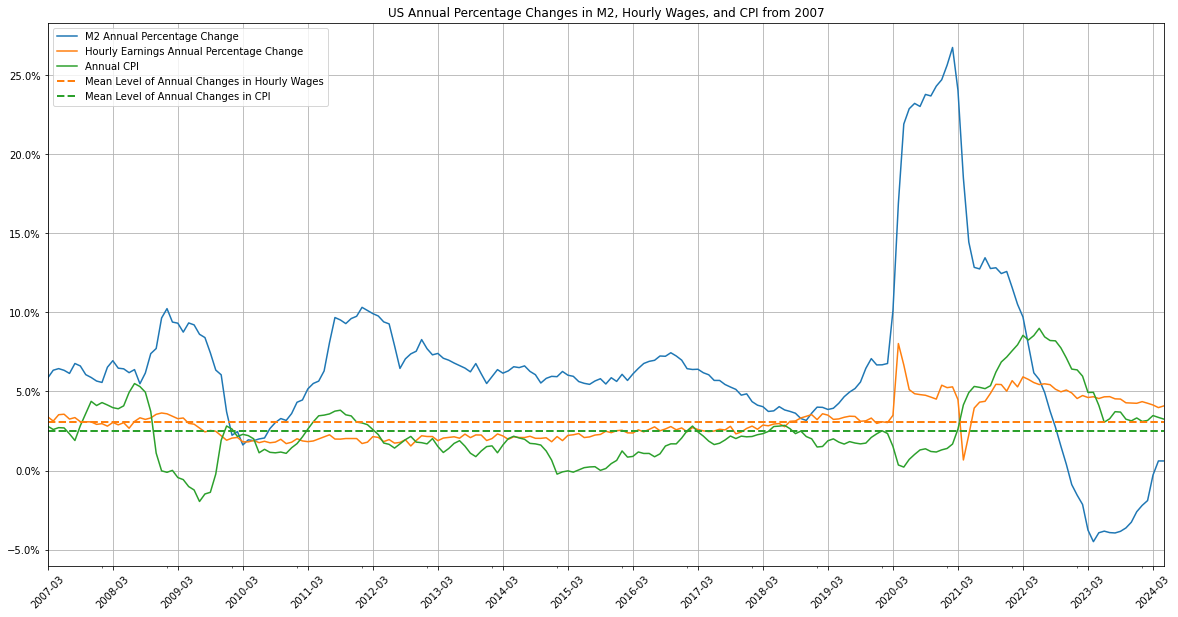

In [32]:
ax = m2_wagei_cpi.plot(figsize=(20,10), grid=True, title=GRAPH_TITLE % m2_wagei_cpi.index[0].year,
                       xticks=m2_wagei_cpi.index[::12], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=mean_level_wagei, lw=2, ls='--', c='#ff7f0e', label=LABEL_MEAN_WAGEI)
ax.axhline(y=mean_level_cpi, lw=2, ls='--', c='#2ca02c', label=LABEL_MEAN_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_wagei_cpi.index[::12])))

#### Zooming in on the past 5 years

In [33]:
m2_wagei_cpi_from_2017 = m2_wagei_cpi.loc['2017':]

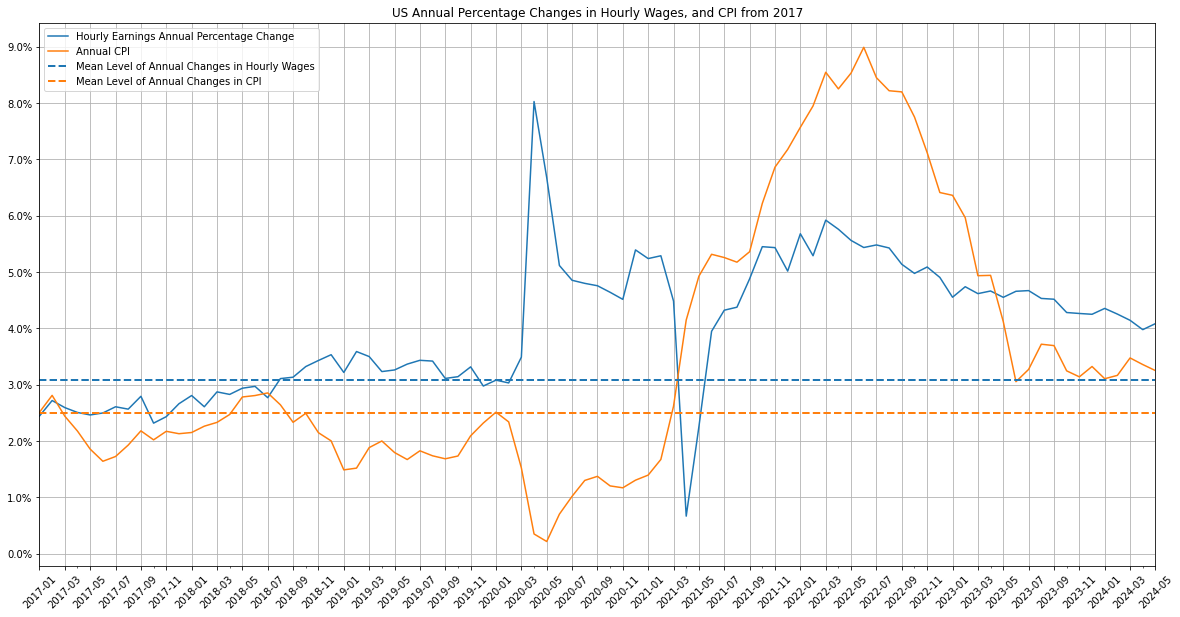

In [34]:
ax = m2_wagei_cpi_from_2017.iloc[:,1:].plot(figsize=(20,10), grid=True, title='US Annual Percentage Changes in Hourly Wages, and CPI from %d' % m2_wagei_cpi_from_2017.index[0].year,
                       xticks=m2_wagei_cpi_from_2017.index[::2], xlabel='', rot=45, yticks=np.arange(0, .1, .01))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=mean_level_wagei, lw=2, ls='--', c='#1f77b4', label=LABEL_MEAN_WAGEI)
ax.axhline(y=mean_level_cpi, lw=2, ls='--', c='#ff7f0e', label=LABEL_MEAN_CPI)
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, m2_wagei_cpi_from_2017.index[::2])))

In [35]:
m2_wagei_cpi_from_2017.tail()

,M2 Annual Percentage Change,Hourly Earnings Annual Percentage Change,Annual CPI
DATE,,,
2024-01-01,-2.2075%,4.3544%,3.1060%
2024-02-01,-1.9007%,4.2534%,3.1657%
2024-03-01,-0.2904%,4.1429%,3.4751%
2024-04-01,0.6040%,3.9773%,3.3577%
2024-05-01,0.6042%,4.0847%,3.2502%


In [36]:
print('Mean level of Annual Percentage Change in Hourly Wages since {:%Y-%m}: {:.2%}'
      .format(m2_wagei_cpi.index[0], mean_level_wagei))
print('Mean level of Annual CPI since {:%Y-%m}: {:.2%}'
      .format(m2_wagei_cpi.index[0].date(), mean_level_cpi))

Mean level of Annual Percentage Change in Hourly Wages since 2007-03: 3.08%
Mean level of Annual CPI since 2007-03: 2.50%


In [37]:
pd.options.display.max_rows = 20
m2_wagei_cpi_from_2017.loc['2020':,:].iloc[:,1:]

,Hourly Earnings Annual Percentage Change,Annual CPI
DATE,,
2020-01-01,3.0808%,2.5123%
2020-02-01,3.0314%,2.3397%
2020-03-01,3.4892%,1.5231%
2020-04-01,8.0274%,0.3499%
2020-05-01,6.6762%,0.2162%
...,...,...
2024-01-01,4.3544%,3.1060%
2024-02-01,4.2534%,3.1657%
2024-03-01,4.1429%,3.4751%


#### Wage inflation based on monthly and quarterly changes
In the previous part of this notebook I looked at wage inflation based on changes compared to 12 months ago. This is the standard way of determining annual percentage cahnges. Below I look at monthly changes in wages and then translate them into annual percentage changes using the following simple formula for translating monthly wage changes into annual percentage changes:

$$\left(\left({\text{level of month n+1} \over \text{level of month n}}\right)^{12}-1\right)\times 100\% $$

And then the same for translating quarterly changes into annual rates:

$$\left(\left({\text{level of month n+1} \over \text{level of month n-2}}\right)^4-1\right)\times 100\% $$

In [38]:
wagei = web.get_data_fred('CES0500000003', start=date(2006, 3, 1), end=report_end)
wagei_monthly = wagei.pct_change(fill_method='bfill').loc['2017':, 'CES0500000003'].rename('Hourly Earnings Percentage Change over Prev Month')
wagei_annual = ((wagei/wagei.shift(1)).pow(12)-1).loc['2017':, 'CES0500000003'].rename('Hourly Earnings Change over Prev Month at Annual Rate')
wagei_quarterly = ((wagei/wagei.shift(3)).pow(4)-1).loc['2017':, 'CES0500000003'].rename('Hourly Earnings Change over Prev 3 Months at Annual Rate')

In [39]:
wagei_df = pd.concat([m2_wagei_cpi_from_2017.iloc[:,1], wagei_monthly,
                      wagei_quarterly, wagei_annual], axis=1)

In [40]:
wagei_df.loc['2020':]

,Hourly Earnings Annual Percentage Change,Hourly Earnings Percentage Change over Prev Month,Hourly Earnings Change over Prev 3 Months at Annual Rate,Hourly Earnings Change over Prev Month at Annual Rate
DATE,,,,
2020-01-01,3.0808%,0.2467%,3.0089%,3.0014%
2020-02-01,3.0314%,0.3868%,2.8519%,4.7414%
2020-03-01,3.4892%,0.7706%,5.7602%,9.6491%
2020-04-01,8.0274%,4.3100%,23.9783%,65.9257%
2020-05-01,6.6762%,-0.9663%,17.4278%,-10.9992%
...,...,...,...,...
2024-01-01,4.3544%,0.4950%,4.8968%,6.1050%
2024-02-01,4.2534%,0.1449%,3.9124%,1.7525%
2024-03-01,4.1429%,0.3762%,4.1396%,4.6085%


In [41]:
import seaborn as sns
cm = sns.color_palette('Blues', as_cmap=True)
IDX_FORMAT = '{:%Y-%m}'
pd.options.display.max_rows = 15

In [42]:
wagei_df2 = wagei_df.loc['2020':, wagei_df.columns[[0,2]]]
wagei_df2.tail(18).style.format_index(IDX_FORMAT).format('{:.2%}')\
    .set_properties(subset=wagei_df2.columns, **{'width': '200px'})\
    .set_table_styles([{'selector': 'th', 'props': 'text-align: right; width: 100px'}])\
    .background_gradient(cmap=cm)

,Hourly Earnings Annual Percentage Change,Hourly Earnings Change over Prev 3 Months at Annual Rate
DATE,,
2022-12,4.90%,5.01%
2023-01,4.55%,4.60%
2023-02,4.74%,3.96%
2023-03,4.62%,4.57%
2023-04,4.66%,4.55%
2023-05,4.55%,4.79%
2023-06,4.66%,4.77%
2023-07,4.67%,4.87%
2023-08,4.53%,4.49%
